# iFood Data Analyst Case

The proposed case considers a company operating in the retail food sector, selling products in five main categories (wines, rare meat products, exotic fruits, specially prepared fish products and sweet products), classified according to gold and regular standards. The customers dispose of three sales channels to acquire the products, to cite: physical stores, catalogs and the company's website.

Although the company presented stable revenues in the last three years, the growth perspectives for the next triennium are not optimistic. The company intends to overcome this situation by focusing on special marketing campaigns. With this aim, 2240 customers, selected at random, were contacted by phone to talk about the acquisition of a gadget. These customers were labeled with 1 or 0 as they did or not buy the offered product. Besides that, another personal information and the responses of the customers to five previous campaigns were also collected and stored in a dataset.

The objective of this study case is to obtain a predictive model able to classify when a customer will or not accept an offer, given the costumer's personal information. It is also desirable to segment the costumers according to their behaviors.

The fields in the aforementioned dataset comprise:
* AcceptedCmp1 to AcceptedCmp5: 1 if the customer accepted the offer in the respective campaign, 0 otherwise;
* Response (target): 1 if the customer accepted the offer in the last campaign, 0 otherwise;
* Complain: 1 if the customer complained in the last two years, 0 otherwise;
* DtCustomer: date of the customer's enrollment with the company;
* Customer's level of education;
* Customer's marital status;
* Number of children in customer's household;
* Number of teenagers in customer's household;
* Customer's yearly household income;
* MntFishProducts: amount spent in fish products in the last two years;
* MntMeatProducts: amount spent in meat products in the last two years;
* MntSweetProducts: amount spent in sweet products in the last two years;
* MntFruits: amount spent in fruits in the last two years;
* MntWines: amount spent in wines products in the last two years;
* MntGoldProds: amount spent in gold products in the last two years;
* NumDealsPurchases: number of purchases made with discount;
* NumCatalogPurchases: number of purchases made using catalogue;
* NumStorePurchases: number of purchases made directly in stores;
* NumWebPurchases: number of purchases made in the company's website;
* NumWebVisitsMonth: number of visits to the company's website in the last month;
* Recency: number of days since the last purchase.

The modeling approach presented in this report was performed using, mostly, sklearn modules. The imported classes are exhibited in the following code cell. The next sections address the data engineering, the prediction model and the segmentation of the customers, respectively. As it will be presented, the classification problem was compromised by an imbalance in the classes corresponding to the responses of the customers. Negative responses were much more often. This problem was attenuated by oversampling the minoritary class. The segmentation approach, on its hand, was successfully performed through the k-means clustering.

In [28]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.utils import column_or_1d
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

mpl.rcParams['figure.figsize'] = (10, 7)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data Engineering

The following table exhibits the five first entries of the dataset. Each one of the columns corresponds to the answers of a customer in the marketing campaign, with the target label being given by the Response variable. It is possible to see that the dataset contains mixed categorical and numerical data. Some of the categorical data are already in numerical format, like the Complain variable, that accepts only the values 0 or 1. The Education and Marital Status variable, on the other hand, present sample spaces composed by strings.

In [29]:
df = pd.read_csv('ml_project1_data.csv', header = 0, low_memory = False)
df.head().transpose()

0           1           2           3  \
ID                         5524        2174        4141        6182   
Year_Birth                 1957        1954        1965        1984   
Education            Graduation  Graduation  Graduation  Graduation   
Marital_Status           Single      Single    Together    Together   
Income                  58138.0     46344.0     71613.0     26646.0   
Kidhome                       0           1           0           1   
Teenhome                      0           1           0           0   
Dt_Customer          2012-09-04  2014-03-08  2013-08-21  2014-02-10   
Recency                      58          38          26          26   
MntWines                    635          11         426          11   
MntFruits                    88           1          49           4   
MntMeatProducts             546           6         127          20   
MntFishProducts             172           2         111          10   
MntSweetProducts             88           1          21           3   
MntGoldProds                 88           6          42           5   
NumDealsPurchases             3           2           1           2   
NumWebPurchases               8           1           8           2   
NumCatalogPurchases          10           1           2           0   
NumStorePurchases             4           2          10           4   
NumWebVisitsMonth             7           5           4           6   
AcceptedCmp3                  0           0           0           0   
AcceptedCmp4                  0           0           0           0   
AcceptedCmp5                  0           0           0           0   
AcceptedCmp1                  0           0           0           0   
AcceptedCmp2                  0           0           0           0   
Complain                      0           0           0           0   
Z_CostContact                 3           3           3           3   
Z_Revenue                    11          11          11          11   
Response                      1           0           0           0   

                              4  
ID                         5324  
Year_Birth                 1981  
Education                   PhD  
Marital_Status          Married  
Income                  58293.0  
Kidhome                       1  
Teenhome                      0  
Dt_Customer          2014-01-19  
Recency                      94  
MntWines                    173  
MntFruits                    43  
MntMeatProducts             118  
MntFishProducts              46  
MntSweetProducts             27  
MntGoldProds                 15  
NumDealsPurchases             5  
NumWebPurchases               5  
NumCatalogPurchases           3  
NumStorePurchases             6  
NumWebVisitsMonth             5  
AcceptedCmp3                  0  
AcceptedCmp4                  0  
AcceptedCmp5                  0  
AcceptedCmp1                  0  
AcceptedCmp2                  0  
Complain                      0  
Z_CostContact                 3  
Z_Revenue                    11  
Response                      0

Some of the dataset fields, however, are not informative or even redundant about the customers' personal information. The variable ID, for example, is useful only to identify different entries, while the variable DtCustomer is redundant given the existence of another fields quantifying the recency of the customers' activities in the company's sales channels (e. g., Complain and Recency). For the exposed reasons, these fields were dropped from the dataset, together with the fields ZCostContact and ZRevenue. The last two present the same values for all entries, not furnishing any information about the customers.

In [30]:
df = df.drop(['ID', 'Dt_Customer', 'Z_CostContact',
              'Z_Revenue'], axis = 1)

The categorical variables comprising the customers' education level and the customers' marital status require a numerical encoding. The first field may be treated through ordinal encoding, since usually there is a positive correlation between an academic title and the number of years to achieve it. The marital status, on the other hand, cannot be treated like this. The sample spaces of these variables are exposed below. 

In [31]:
print(set(df['Education']))
print(set(df['Marital_Status']))

{'Basic', '2n Cycle', 'Master', 'PhD', 'Graduation'}
{'Single', 'Alone', 'Married', 'Absurd', 'Widow', 'Divorced', 'Together', 'YOLO'}


The sklearn.preprocessing.LabelEncoder() class was used to encode the values in Education field into integers from 0 up to 4. However the fit() method of this encoder does not preserve the order of the categories list, but sort it in an alphanumerical order. So, the class MyLabelEncoder() was defined with the purpose to overwrite the respective method.

The marital status variable was transformed by means of one hot encoding. This method associates the categorical variable with a binary array with only one non zero element, whose position depends on the value of the variable. For example, given the list of categories ['Single', 'Alone', 'Married', 'Absurd', 'Widow', 'Divorced', 'Together', 'YOLO'], an entry with the value 'Married' would be encoded as [0, 0, 1, 0, 0, 0, 0, 0].

The table presented after the following code cell exhibits the transformed dataset, with all variables assuming numerical values. The field Marital Status was substituted by eight other features with column labels given by the values in the sample space of the original variable. 

In [32]:
class MyLabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn = True)
        self.classes_ = pd.Series(y).unique()
        return self

categories = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']

enc = MyLabelEncoder()
enc.fit(categories)
df['Education'] = enc.transform(df['Education'])

categories = np.array(list(set(df['Marital_Status'])))
marital_status = df['Marital_Status'].apply(lambda x: (categories == x).astype(int))
marital_status = pd.DataFrame(np.stack(marital_status.values),
                             columns = categories)

df = pd.concat([df, marital_status], axis = 1)
df.pop('Marital_Status')

df.head().transpose()

0        1        2        3        4
Year_Birth            1957.0   1954.0   1965.0   1984.0   1981.0
Education                2.0      2.0      2.0      2.0      4.0
Income               58138.0  46344.0  71613.0  26646.0  58293.0
Kidhome                  0.0      1.0      0.0      1.0      1.0
Teenhome                 0.0      1.0      0.0      0.0      0.0
Recency                 58.0     38.0     26.0     26.0     94.0
MntWines               635.0     11.0    426.0     11.0    173.0
MntFruits               88.0      1.0     49.0      4.0     43.0
MntMeatProducts        546.0      6.0    127.0     20.0    118.0
MntFishProducts        172.0      2.0    111.0     10.0     46.0
MntSweetProducts        88.0      1.0     21.0      3.0     27.0
MntGoldProds            88.0      6.0     42.0      5.0     15.0
NumDealsPurchases        3.0      2.0      1.0      2.0      5.0
NumWebPurchases          8.0      1.0      8.0      2.0      5.0
NumCatalogPurchases     10.0      1.0      2.0      0.0      3.0
NumStorePurchases        4.0      2.0     10.0      4.0      6.0
NumWebVisitsMonth        7.0      5.0      4.0      6.0      5.0
AcceptedCmp3             0.0      0.0      0.0      0.0      0.0
AcceptedCmp4             0.0      0.0      0.0      0.0      0.0
AcceptedCmp5             0.0      0.0      0.0      0.0      0.0
AcceptedCmp1             0.0      0.0      0.0      0.0      0.0
AcceptedCmp2             0.0      0.0      0.0      0.0      0.0
Complain                 0.0      0.0      0.0      0.0      0.0
Response                 1.0      0.0      0.0      0.0      0.0
Single                   1.0      1.0      0.0      0.0      0.0
Alone                    0.0      0.0      0.0      0.0      0.0
Married                  0.0      0.0      0.0      0.0      1.0
Absurd                   0.0      0.0      0.0      0.0      0.0
Widow                    0.0      0.0      0.0      0.0      0.0
Divorced                 0.0      0.0      0.0      0.0      0.0
Together                 0.0      0.0      1.0      1.0      0.0
YOLO                     0.0      0.0      0.0      0.0      0.0

The Response field has an imbalance between the two classes in the target variable. As mentioned before, the negative response is much more likely to happen. The positive responses correspond only to 14.9% of the total of answers and this may compromise the accuracy of a classification approach. For example, a classifier that label all responses as negative would have 85.1% of accuracy even without modeling the customers' behavior at all.

In [33]:
print(Counter(df['Response']))

Counter({0: 1906, 1: 334})


It will be shown that this problem may be solved by oversampling the minoritary class and by employing the area under the receiving operating characteristic curve as a score for the classifier performance. However, before this, another preliminary transformations can be applied to the dataset to make the modeling approach more suitable.

The table below presents statistics of each variable in the dataset. The maximum values of some variables deviate excessively from respective mean values. For example, the household income variable. The maximum value is equal to 666666.0 monetary unities (m. u.), while the mean value is 52247.25 m. u. This maximum is about ten times bigger than the value that divide the income distribution between the 75% lower and 25% higher incomes (i. e., 68522.00 m.u.). This suggests that most samples are accumulated between the lower values, and a model trained to represent this data may describe well the customers' behavior for low household incomes and have a poor accuracy at high household incomes.

In [34]:
stats = df.describe().transpose()
stats

count          mean           std     min       25%  \
Year_Birth           2240.0   1968.805804     11.984069  1893.0   1959.00   
Education            2240.0      2.460268      1.004337     0.0      2.00   
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
Kidhome              2240.0      0.444196      0.538398     0.0      0.00   
Teenhome             2240.0      0.506250      0.544538     0.0      0.00   
Recency              2240.0     49.109375     28.962453     0.0     24.00   
MntWines             2240.0    303.935714    336.597393     0.0     23.75   
MntFruits            2240.0     26.302232     39.773434     0.0      1.00   
MntMeatProducts      2240.0    166.950000    225.715373     0.0     16.00   
MntFishProducts      2240.0     37.525446     54.628979     0.0      3.00   
MntSweetProducts     2240.0     27.062946     41.280498     0.0      1.00   
MntGoldProds         2240.0     44.021875     52.167439     0.0      9.00   
NumDealsPurchases    2240.0      2.325000      1.932238     0.0      1.00   
NumWebPurchases      2240.0      4.084821      2.778714     0.0      2.00   
NumCatalogPurchases  2240.0      2.662054      2.923101     0.0      0.00   
NumStorePurchases    2240.0      5.790179      3.250958     0.0      3.00   
NumWebVisitsMonth    2240.0      5.316518      2.426645     0.0      3.00   
AcceptedCmp3         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp4         2240.0      0.074554      0.262728     0.0      0.00   
AcceptedCmp5         2240.0      0.072768      0.259813     0.0      0.00   
AcceptedCmp1         2240.0      0.064286      0.245316     0.0      0.00   
AcceptedCmp2         2240.0      0.013393      0.114976     0.0      0.00   
Complain             2240.0      0.009375      0.096391     0.0      0.00   
Response             2240.0      0.149107      0.356274     0.0      0.00   
Single               2240.0      0.214286      0.410418     0.0      0.00   
Alone                2240.0      0.001339      0.036580     0.0      0.00   
Married              2240.0      0.385714      0.486872     0.0      0.00   
Absurd               2240.0      0.000893      0.029874     0.0      0.00   
Widow                2240.0      0.034375      0.182231     0.0      0.00   
Divorced             2240.0      0.103571      0.304772     0.0      0.00   
Together             2240.0      0.258929      0.438144     0.0      0.00   
YOLO                 2240.0      0.000893      0.029874     0.0      0.00   

                         50%       75%       max  
Year_Birth            1970.0   1977.00    1996.0  
Education                2.0      3.00       4.0  
Income               51381.5  68522.00  666666.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
MntWines               173.5    504.25    1493.0  
MntFruits                8.0     33.00     199.0  
MntMeatProducts         67.0    232.00    1725.0  
MntFishProducts         12.0     50.00     259.0  
MntSweetProducts         8.0     33.00     263.0  
MntGoldProds            24.0     56.00     362.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Response                 0.0      0.00       1.0  
Single                   0.0      0.00       1.0  
Alone                    0.0      0.00       1.0  
Married                  0.0      1.00       1.0  
Absurd                   0.0      0.00       1.0  
W

One way to deal with this unevenness in the distribution is to apply a power transformation to the data. In this work, the two-parameters Box-Cox transformation was employed:
$$
x^{(\lambda_1,\lambda_2)} = \frac{(p + \lambda_2)^{\lambda_1} - 1}{\lambda_1}
$$
In the limit case when $\lambda_1 \rightarrow 0$, the transformation is given by:
$$
x^{(0, \lambda_2)} = \ln(x + \lambda_2)
$$
The Box-Cox transformation approximately linearizes the variable $x$ and makes its distribution more normal-like. These characteristics are more desirable for several modeling approaches, that hypothesize the linearity and normality of the dependent variables of the model.

The next code cell applies the aforementioned transformation, with parameters $\lambda_1 = 0$ and $\lambda_2 = 0.01$, to the dataset variables whose difference between the maximum and mean values was higher than three standard deviances. To avoid applying the transformation to binary variables, an additional condition was stablished, requiring the maximum value to be higher than 1.0. The parameter $\lambda_2$ was set to a non-zero value because some variables present minimum values equal to zero, and a logarithmic transformation of these would diverge to $-\infty$.

In [35]:
columns = (stats['max'] - stats['mean'] > 3*stats['std'])
columns &= (stats['max'] > 1)
columns = stats[columns].transpose().columns.values

df['Log ' + columns] = np.log(df[columns] + .01)
df = df.drop(columns, axis = 1)

df.describe().transpose()

count         mean        std          min  \
Year_Birth               2240.0  1968.805804  11.984069  1893.000000   
Education                2240.0     2.460268   1.004337     0.000000   
Kidhome                  2240.0     0.444196   0.538398     0.000000   
Teenhome                 2240.0     0.506250   0.544538     0.000000   
Recency                  2240.0    49.109375  28.962453     0.000000   
NumStorePurchases        2240.0     5.790179   3.250958     0.000000   
AcceptedCmp3             2240.0     0.072768   0.259813     0.000000   
AcceptedCmp4             2240.0     0.074554   0.262728     0.000000   
AcceptedCmp5             2240.0     0.072768   0.259813     0.000000   
AcceptedCmp1             2240.0     0.064286   0.245316     0.000000   
AcceptedCmp2             2240.0     0.013393   0.114976     0.000000   
Complain                 2240.0     0.009375   0.096391     0.000000   
Response                 2240.0     0.149107   0.356274     0.000000   
Single                   2240.0     0.214286   0.410418     0.000000   
Alone                    2240.0     0.001339   0.036580     0.000000   
Married                  2240.0     0.385714   0.486872     0.000000   
Absurd                   2240.0     0.000893   0.029874     0.000000   
Widow                    2240.0     0.034375   0.182231     0.000000   
Divorced                 2240.0     0.103571   0.304772     0.000000   
Together                 2240.0     0.258929   0.438144     0.000000   
YOLO                     2240.0     0.000893   0.029874     0.000000   
Log Income               2216.0    10.753800   0.505863     7.455882   
Log MntWines             2240.0     4.598112   1.977598    -4.605170   
Log MntFruits            2240.0     1.286589   3.050129    -4.605170   
Log MntMeatProducts      2240.0     4.073931   1.633681    -4.605170   
Log MntFishProducts      2240.0     1.656106   3.127157    -4.605170   
Log MntSweetProducts     2240.0     1.250942   3.108023    -4.605170   
Log MntGoldProds         2240.0     2.905985   1.800242    -4.605170   
Log NumDealsPurchases    2240.0     0.526849   0.983034    -4.605170   
Log NumWebPurchases      2240.0     1.078592   1.099934    -4.605170   
Log NumCatalogPurchases  2240.0    -0.473427   2.549854    -4.605170   
Log NumWebVisitsMonth    2240.0     1.506675   0.732153    -4.605170   

                                 25%          50%          75%          max  
Year_Birth               1959.000000  1970.000000  1977.000000  1996.000000  
Education                   2.000000     2.000000     3.000000     4.000000  
Kidhome                     0.000000     0.000000     1.000000     2.000000  
Teenhome                    0.000000     0.000000     1.000000     2.000000  
Recency                    24.000000    49.000000    74.000000    99.000000  
NumStorePurchases           3.000000     5.000000     8.000000    13.000000  
AcceptedCmp3                0.000000     0.000000     0.000000     1.000000  
AcceptedCmp4                0.000000     0.000000     0.000000     1.000000  
AcceptedCmp5                0.000000     0.000000     0.000000     1.000000  
AcceptedCmp1                0.000000     0.000000     0.000000     1.000000  
AcceptedCmp2                0.000000     0.000000     0.000000     1.000000  
Complain                    0.000000     0.000000     0.000000     1.000000  
Response                    0.000000     0.000000     0.000000     1.000000  
Single                      0.000000     0.000000     0.000000     1.000000  
Alone                       0.000000     0.000000     0.000000     1.000000  
Married                     0.000000     0.000000     1.000000     1.000000  
Absurd                      0.000000     0.000000     0.000000     1.000000  
Widow                       0.000000     0.000000     0.000000     1.000000  
Divorced                    0.000000     0.000000     0.000000     1.000000  
Together                    0.000000     0.000000     1.000000     1.000000  
YOLO       

The next step procedure corresponds to dividing the dataset into a training and validation subsets. A good data engineering practice is to choose these subsets to have 80 and 20% of the size of the original subset. Before splitting the dataset, however, entries containing missing values were removed from the it. The datasets were also normalized between 0.0 and 1.0 by means of the sklearn.preprocessing.MinMaxScaler(). This normalization was performed because some classifying models, like logistic regression and multilayer perceptron classifiers, employ activation functions that saturates for high values in the input space.

The training dataset comprises one array of inputs, containing 31 features of the customers' behavior, and one array of outputs, containing the labels correspondent to the customers' responses. Thereby, the classification problem consists in mapping the input space into the output space in a way that a given metric is minimized.

In [36]:
values = df.values
missing_values = np.isnan(values).any(axis = 1)
values = values[~missing_values]
df = pd.DataFrame(values, columns = df.columns)

train_df, val_df = train_test_split(df, test_size = 0.2)

train_labels = np.array(train_df.pop('Response'))
val_labels = np.array(val_df.pop('Response'))

train_features = np.array(train_df)
val_features = np.array(val_df)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)

scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (1772,)
Validation labels shape: (444,)
Training features shape: (1772, 31)
Validation features shape: (444, 31)


It is still possible to hypothesize that some of these 31 features are not correlated with the customers' responses. In this work, the feature selection was addressed through a chi-squared $\chi^2$ test. This method is used to test when a given input variable is independent (null hypothesis) of the occurrence of a given class. The $\chi^2$ test is used to test the independence between categorical variables. Nonetheless, even with some variables in the dataset being not categorical, it is possible to argue that the amounts of values in the sample spaces of some numerical variables are small when compared with the number of observations in the dataset. For example, although the Teenhome field in the training dataset have 1772 entries, its sample space has only three values (0.0, 0.5 and 1.0). So it is possible to treat this variable as categorical.

Considering a random sample with $N$ observations from a population in which each observation falls into one of a given number mutually exclusive classes, the $\chi^2$ test assumes that the statistic:
$$
X^2 = \sum_{i = 1}^{k_1}\sum_{j = 1}^{k_2}\frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$
converges to a $\chi^2$ distribution as $N \rightarrow \infty$. In the previous equation, the term $O_{ij}$ accounts for the observed joint frequency associated with the $i$ and $j$-th, $i \in \{1, ..., k_1\}$ and $j \in \{1, ..., k_2\}$, values in the sample spaces of two variables with $k_1$ and $k_2$ classes, respectively. The expected joint frequency $E_{ij}$ is given by:
$$
E_{ij} = Np_{i\cdot}p_{\cdot j}
$$
where
$$
p_{i\cdot} = \sum_{j = 1}^{k_2}\frac{O_{ij}}{N}, \text{ } p_{\cdot j} = \sum_{i = 1}^{k_1}\frac{O_{ij}}{N}
$$

When the statistic $X^2$ assumes a high value, the null hypothesis is rejected and the occurrence of a given feature and a given class can be considered as dependents. In this work, the dependence was assume for $p(\chi^2) < 0.05$ (i. e., the test rejects the independence between the variables with 95% of accuracy). This procedure leaded to the selection of 15 features, assumed to be decisive on the customers' behavior prediction.

In [37]:
chi2score = chi2(train_features, train_labels)
K = np.array([x for x in chi2score[1] if x < .05]).size

print('Total number of features:', train_features[0].size)
print('Number of selected features:', K)

kbest = SelectKBest(score_func = chi2, k = K)

train_features = kbest.fit_transform(train_features, train_labels)
val_features = kbest.transform(val_features)

Total number of features: 31
Number of selected features: 15


The selected features include the customers' responses in the previous campaigns, the marital status features, the number of teenagers at home, the amount spent on fruits, meat and sweet products and also the number of purchases made using catalogue. The numerical variables in this input space have sample spaces with sizes:
* Teenhome: 3;
* Log MntFruits: 130;
* Log MntMeatProducts: 143;
* Log MntSweetProducts: 140;
* Log NumCatalogPurchases: 14.

Even so, it is not possible to reject that maybe some features were rejected by the $\chi^2$ test due to the inadequacy of this for continuous variables. For instance, in the original dataset, the variable Log Income has sample space with 1974 values. This is comparable with the total number of observations (2240), implying that many values of this variable are observed only once. However, a better addressing of this issue will be left for future works. As it will be presented, good results were found taking the 15 selected features into account.

In [38]:
kbest_columns = kbest.get_support()
print(train_df.columns.values[kbest_columns])

['Teenhome' 'AcceptedCmp3' 'AcceptedCmp4' 'AcceptedCmp5' 'AcceptedCmp1'
 'AcceptedCmp2' 'Single' 'Married' 'Absurd' 'Divorced' 'Together'
 'Log MntFruits' 'Log MntMeatProducts' 'Log MntSweetProducts'
 'Log NumCatalogPurchases']


The transformed datasets, containing only the selected features, have dimensions given in the results of the following code cell. It is important to notice that the $\chi^2$ test was performed using only samples in the training subset. The validation subset is assumed to be unknown in all the steps up to the fitting of the models.

In [39]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (1772,)
Validation labels shape: (444,)
Training features shape: (1772, 15)
Validation features shape: (444, 15)


Since the class sklearn.model_selection.train_test_split() shuffles the dataset before splitting it, each execution of the former will result in different training and validation datasets. This may affect the number of selected features in the $\chi^2$ test, especially when the number of observations in the samples are not so big. Different runs of the former code cells produced input spaces with 13 to 15 features, usually.

Although the modeling results were not so impacted by these small changes in the number of features, the results of the data engineering procedure were saved in a .pkl file. This can be considered a good practice, since it allows to perform and evaluate more consistently the modeling approaches.

In [40]:
filename = 'globalsave.pkl'
dill.dump_session(filename)

## Prediction of the costumer behavior

Using the training dataset obtained in the data engineering procedure, it is possible to verify that only 15.3% of the customers' responses were positive. Thereby, the oversampling of the minoritary class was used to avoid poor classifying performance.

In [41]:
dill.load_session(filename)
print(Counter(train_labels))

Counter({0.0: 1500, 1.0: 272})


The imblearn library allows the oversampling of the minoritary class and undersampling of the majoritary class through the imblearn.over_sampling.SMOTE() and imblearn.under_sampling.RandomUnderSampler() classes. In both functions, the sampling_strategy parameter corresponds to the desired frequency of the respective class in the dataset. In this work, good results were obtained by oversampling the minoritary class up to 30% of the dataset size, and by keeping the sampling of the majoritary class unchanged.

In [42]:
over = SMOTE(sampling_strategy = .3)
under = RandomUnderSampler(sampling_strategy = 1)

The list below contains the models addressed in this classifying procedure. The logistic regression classifier and the support vector machine take by hypothesis that the samples are linearly separable. This implies that the observations corresponding to each class can be divided by a hyperplane in the input space. The multilayer perceptron generalizes this concept for non-linearly separable samples. This classifier is a feedforward neural network containing one or more hidden layers with nonlinear activation functions. In this case, the parameters of the model are adjusted in order to tune a hypersurface in the input space with the aim to optimize the classification of the observations.

Instead of tuning a hypersurface, a decision tree defines a set of rules to classify an input. The result is an algorithm composed by conditional control statements. K-neighbors method, on its role, estimates the label of an input by comparing its location in the input space with the $k$ nearest neighbors. The prediction corresponds to the most common class between these neighbors.

In [43]:
models = [['Multilayer Perceptron', MLPClassifier(max_iter = 10000)],
          ['Decision Tree', DecisionTreeClassifier()],
          ['Logistic Regression', LogisticRegression()],
          ['K-neighbours', KNeighborsClassifier()],
          ['Support Vector Machine', SVC(gamma = 'auto',
                                         probability = True)]]

The classes sklearn.model_selection.RepeatedStratifiedKFold() and sklearn.model_selection.cross_val_score() were used to select between the aforementioned models. This is made by evaluating a score metric through cross-validation. The procedure was repeated three times for each model, considering the mean value of the area under the curve (AUC) of the reciever operator characteristic (ROC) curve as score.

In binary classification problems, the ROC AUC score furnishes the probability of the true positive rate (TPR) against the probability of the false positive rate (FPR) for several threshold values of the classifier. These quantities are given in terms of the number of true positives (TP), false negatives (FN), false positives (FP) and true negatives (TN):
$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \text{ } \text{FPR} =\frac{\text{FP}}{\text{FP} + \text{TN}}
$$

A ROC of 0.5 means the model cannot distinguish between the classes of the dependent variable, producing noisy results. A value of 1 means that the model is able to classify all the samples correctly, while a value of -1 means that the model labels all samples from class 1 as belonging to class 0 and vice-versa. Thus, the probability of classifying a sample correctly increases with the value of the ROC.

In [44]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3,
                             random_state = 1)

res = []

for clf in models:
    steps = [('over', over), ('under', under), ('model', clf[1])]
    pipeline = Pipeline(steps = steps)  
    scores = cross_val_score(pipeline, train_features, train_labels,
                             scoring = 'roc_auc', cv = cv, n_jobs = -1)
    res.append([clf[0], np.round(np.mean(scores), 3)])
    
print(tabulate(res,
               headers = ['Classifier', 'Mean ROC AUC'],
               tablefmt = 'orgtbl'))

| Classifier             |   Mean ROC AUC |
|------------------------+----------------|
| Multilayer Perceptron  |          0.791 |
| Decision Tree          |          0.663 |
| Logistic Regression    |          0.811 |
| K-neighbours           |          0.752 |
| Support Vector Machine |          0.808 |


The table in the results of the previous cell exhibited the AUC value of the ROC metric for each one of the proposed models (normalized between 0 and 1). As can be seen, the best results were obtained for the logistic regression model. So, this model was chosen to predict the customers' behavior.

The good performance of the logistic regression classifier and of the support vector machine may imply that the samples are approximately linearly separable. This is a reasonable hypothesis, taking into account the approximated linearization performed by the Box-Cox transformation.

On the other hand, the inferior performance of the multilayer perceptron may be due to regularization issues. By default, the class sklearn.neural_network.MLPClassifier() has 100 neurons in the hidden layer. Thus, there are 1500 trainable weights between the input and the hidden layers, and 100 trainable weights between the hidden and output layers. The total number of weights is comparable to the number of observations in the training sample, and this may jeopardize the results of the modeling. However, this issue was not treated in this work, the effects of the number of hidden layer neurons and of the regularization parameter were left for future approaches.

In [45]:
k = np.argmax(np.array(res)[:, 1])
clf = models[k][1]

print(clf)

LogisticRegression()


The logistic regression model prediction is given by the output of the logistic function $\sigma(\cdot)$ of the linear combination of the values of the features. The mathematical model of the classifier is given by the equations:
$$
y = \sum_{i = 1}^{m}a_ix_i + a_0
$$
$$
p = \sigma(y) = \frac{1}{1 - e^{-y}}
$$
where the term $a_0$ is the bias of the model.

The expression $p = \sigma(y)$ corresponds to the probability of the customer's response to be positive given the features $x_i$, $i \in \{1, ..., m\}$. The following table presents the predictions of the logistic regression classifier for the samples, in the validation dataset, respective to the customers who accepted the offer in the last campaign. As can be seen, the classifier works reasonably well.

In [46]:
steps = [('over', over), ('under', under), ('model', clf)]
pipeline = Pipeline(steps = steps) 
pipeline.fit(train_features, train_labels)

val_predictions = pipeline.predict(val_features)
val_predictions_proba = pipeline.predict_proba(val_features)

res = np.concatenate((val_labels.reshape(-1, 1),
                      val_predictions.reshape(-1, 1),
                     val_predictions_proba), axis = 1)

res = res[val_labels == 1]

print(tabulate(res,
               headers = ['Real', 'Pred.', 'p(0)', 'p(1)'],
               tablefmt = 'orgtbl'))

|   Real |   Pred. |      p(0) |     p(1) |
|--------+---------+-----------+----------|
|      1 |       1 | 0.141975  | 0.858025 |
|      1 |       1 | 0.340931  | 0.659069 |
|      1 |       1 | 0.012062  | 0.987938 |
|      1 |       1 | 0.172055  | 0.827945 |
|      1 |       1 | 0.261668  | 0.738332 |
|      1 |       1 | 0.113574  | 0.886426 |
|      1 |       1 | 0.221734  | 0.778266 |
|      1 |       1 | 0.261906  | 0.738094 |
|      1 |       1 | 0.375156  | 0.624844 |
|      1 |       1 | 0.206761  | 0.793239 |
|      1 |       1 | 0.169945  | 0.830055 |
|      1 |       0 | 0.666073  | 0.333927 |
|      1 |       1 | 0.200437  | 0.799563 |
|      1 |       0 | 0.737831  | 0.262169 |
|      1 |       0 | 0.786305  | 0.213695 |
|      1 |       1 | 0.050133  | 0.949867 |
|      1 |       0 | 0.797395  | 0.202605 |
|      1 |       1 | 0.35658   | 0.64342  |
|      1 |       1 | 0.232805  | 0.767195 |
|      1 |       1 | 0.082724  | 0.917276 |
|      1 |       1 | 0.44466   |

In the former predictions, the threshold was assumed to be 0.5. However, for many samples the model assigned a higher probability for the sample belonging to class 0. This produced a given amount of false negatives. Varying the classifying threshold, the ROC curves for the training and the validation datasets were obtained. The obtained ROC AUC values were 0.82 and 0.76, respectively. This means that the model has about 80% of chance of predicting correctly the response of a customer. 

<Figure size 720x504 with 0 Axes>

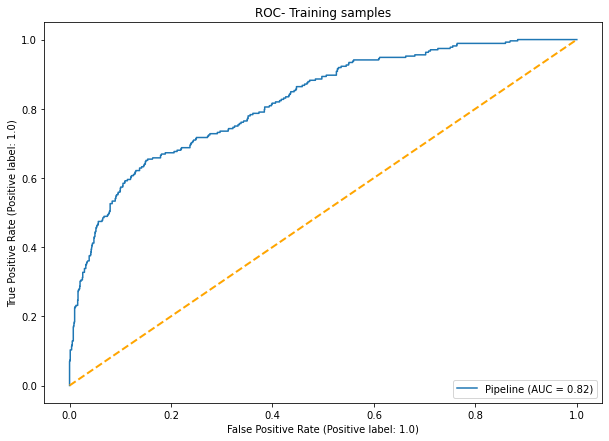

<Figure size 720x504 with 0 Axes>

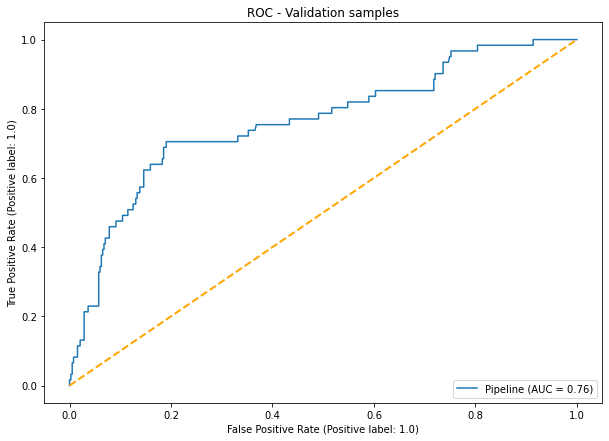

In [47]:
def plot_roc(model, features, labels, title = ''):
    fig = plt.figure()
    _ = RocCurveDisplay.from_estimator(model, features, labels)
    plt.plot([0, 1], [0, 1], color = 'orange', lw = 2, linestyle = "--")
    plt.title(title)
    plt.show()

plot_roc(pipeline, train_features, train_labels, 'ROC- Training samples')
plot_roc(pipeline, val_features, val_labels, 'ROC - Validation samples')

The code in the next cell plots the confusion matrices for the classifier with threshold of 0.5. It is possible to see that the number of false positives exceeded the number of true positives. However, the probability of classifying a positive response correctly is about 70%, both in the training and in the validation datasets. On the other hand, the probability of classifying correctly a negative response is about 80%.

Training samples

True Negatives:  1182
False Positives:  318
True Positives:  184
False Negatives:  88
Total positive responses:  272


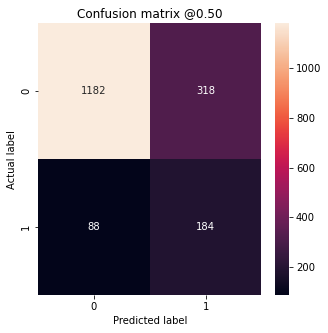

Validation samples

True Negatives:  296
False Positives:  87
True Positives:  43
False Negatives:  18
Total positive responses:  61


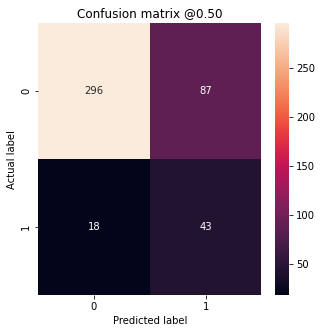

In [48]:
def plot_cm(labels, predictions, p = .5, name = ''):
    cm = confusion_matrix(labels, predictions > p)
    
    print(name + '\n')
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('True Positives: ', cm[1][1])
    print('False Negatives: ', cm[1][0])
    print('Total positive responses: ', np.sum(cm[1]))
    
    fig = plt.figure(figsize = (5, 5))
    sns.heatmap(cm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

plot_cm(train_labels, pipeline.predict(train_features),
        name = 'Training samples')
plot_cm(val_labels, val_predictions,
        name = 'Validation samples')

As can be seen in the confusion matrices, most mislabeling occur in the class 0. Nonetheless assuming a potential purchase that is not going to happen is considerable less harmful than mislabeling a customer that would accept an offer. Comparing with the 15% of positive responses in the last marketing campaign, a model able to predict the customers' behavior with accuracy from 70 to 80% can lead to a huge improvement in the next marketing strategies. Through the logistic regression classifier, it is possible to pick only the customers that are more likely to accept the offer, saving considerable hours of workers responsible by the telemarketing and reducing the costs of the next campaigns.

## Segmentation of the customers

The training dataset, obtained in the data engineering approach, was used again to identify potential segmentations between the customers. For this, the training features (selected after the $\chi^2$ test) and the training were organized in a new dataset. These observations were clustered through the k-means method.

In [49]:
train_df = pd.DataFrame(train_features, 
                    columns = train_df.columns.values[kbest_columns])
train_df['Response'] = train_labels

train_df.head().transpose()

0         1         2         3         4
Teenhome                 0.000000  0.500000  0.500000  0.000000  0.000000
AcceptedCmp3             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp4             0.000000  0.000000  1.000000  0.000000  0.000000
AcceptedCmp5             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp1             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp2             0.000000  0.000000  0.000000  0.000000  0.000000
Single                   1.000000  0.000000  1.000000  1.000000  0.000000
Married                  0.000000  1.000000  0.000000  0.000000  0.000000
Absurd                   0.000000  0.000000  0.000000  0.000000  0.000000
Divorced                 0.000000  0.000000  0.000000  0.000000  0.000000
Together                 0.000000  0.000000  0.000000  0.000000  1.000000
Log MntFruits            0.840299  0.909142  0.880310  0.624035  0.907450
Log MntMeatProducts      1.000000  0.979542  1.000000  0.527013  1.000000
Log MntSweetProducts     0.928957  0.818689  0.915650  0.624035  0.818689
Log NumCatalogPurchases  0.755123  0.718985  0.783172  0.000000  0.581416
Response                 0.000000  0.000000  0.000000  0.000000  0.000000

The k-means method is a popular clustering technique, that estimates for each cluster, out of a total of $K$, a set of of mean coordinates $\hat{x}_k$ in such a way to minimize the cost function:
$$
J(C) = \sum_{k = 1}^K\sum_{C(i) = k}||x_i - \hat{x}_k||^2
$$
where $C(i) = k$ is an encoding function that furnishes the index $k$ of the nearest cluster to the $i$-th sample. The procedure starts with the non-optimal segmentation of the samples in $K$ clusters. After this, the optimization occurs by means the iteration of two steps: I) the mean coordinates are calculated for each cluster $\hat{x}_k$; and II) the segmentation of the samples is updated according to the function $C(i) = k$ for the means obtained in step (I). This process continues until the satisfaction of a stop condition, usually based in the displacement of the clusters along the iterations.

The k-means method always converges to the optimal segmentation of the samples. However, it is still necessary to define the number of clusters $K$. In this work the optimal number of clusters was estimated by means of the elbow method. It is based in the graphical analysis of cost $J(C)$ in function of the number of clusters $K$. Usually, it is possible to observe an elbow separating the regions of underfitting and overfitting in the respective curve. The number of clusters $K$ associated with the elbow is assumed to be the optimal number of clusters.

The following figure exhibits the $K - J(C)$ curve for the training dataset, considering from 1 to 15 clusters.

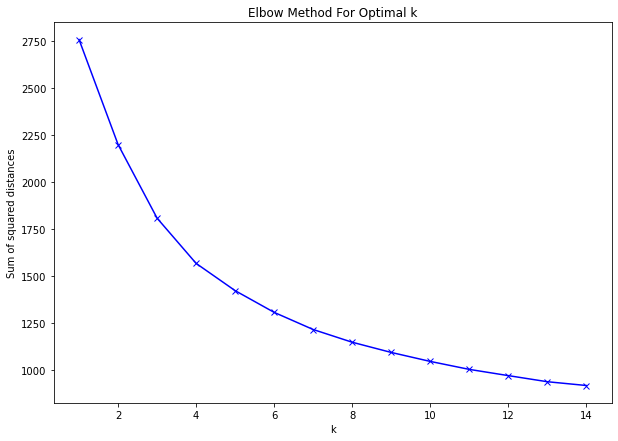

In [50]:
sum_of_squared_distances = []
K = range(1, 15)

for k in K:
    km = KMeans(n_clusters = k).fit(train_df)
    sum_of_squared_distances.append(km.inertia_)
    
fig = plt.figure()
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The curve presents an elbow for $K$ = 4. The next code cell creates an instance of the sklearn.cluster.KMeans() class, segmenting the training dataset into the respective number of clusters.

In [51]:
km = KMeans(n_clusters = 4).fit(train_df)

Even so it is complicated to visualize the results of the k-means clustering. This happens due to the high dimensionality of the entries in the dataset. For each customer, there are $m$ = 16 features associated with the behavior studied in this work, making it impossible to give a raw graphical representation of the observations.

The principal component analysis (PCA) of the training dataset can be realized in order to allow the visualization of the samples segmentation. The PCA corresponds to an orthogonal transformation of a sample of observations, that may be correlated, into a set of components with no linear correlation denominated principal components. Considering a random $m$-dimensional variable $X$ with zero mean, the first principal component $q_1$, is given by the vector that maximizes the variance of the projection $q^tX$:
$$
q_1 = \arg\max_{||q|| = 1} \text{Var}[q^tX]
$$
The $k$-th principal component can by find through the expression:
$$
q_k = \arg\max_{||q|| = 1} \text{Var}[q^t\hat{X}_{k - 1}]
$$
after subtracting the first $k-1$ principal components from $X$:
$$
\hat{X}_{k - 1} = X - \sum_{i = 1}^{k - 1}q_1q_i^tX
$$
It is possible to understand the PCA as an eigenvalue problem:
$$
R\:q = \lambda q 
$$
where $R$ is the correlation matrix $R = \mathbb{E}[XX^t]$ of the random variable $X$. The eigenvalues $\lambda$ correspond to the variances of the respective eigenvectors $q$. Thus, each principal component is responsible for explaining partially the variance in the random variable $X$. Although the former expressions are require the random variable $X$ to have zero mean, they can be extended for situation when the mean is an arbitrary value by replacing $X$ with the difference $X - \mathbb{E}[X]$. 

In data visualization applications, the two or three principal components with the biggest variances are taken to represent the dataset. In this work, two principal components were considered. The sklearn.decomposition.PCA() class was employed with this purpose. The application of the PCA is presented in the following code cell. The mean values of the training dataset were not subtracted previously because the sklearn.decomposition.PCA() does it automatically. As can be seen, the two principal components are responsible for 21.0 and 18.3% of the variance in the sample.

In [52]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(train_df)

print(pca.explained_variance_ratio_)

[0.21001055 0.18290022]


The dataset pc_df was used to receive the results of the PCA and the labels from the k-means clustering.

In [53]:
pc_df = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'])
pc_df['Label'] = km.labels_
pc_df.head()

PC1       PC2  Label
0 -0.468939  0.474691      3
1  0.639363  0.377526      2
2 -0.484618  0.543879      3
3 -0.312991 -0.245104      3
4 -0.641709 -0.016556      0

The figure below plots the two principal components in the training dataset, labeling the observations according to their respective clusters. It is possible to see that the sample is clearly divided in 4 groupings, and that the k-means method converged to an optimal estimative of these.

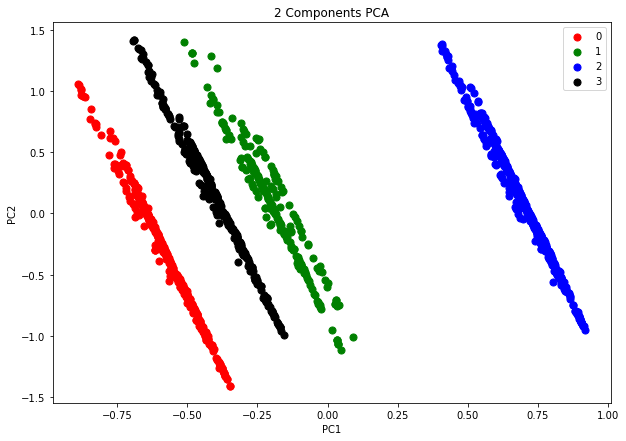

In [54]:
fig = plt.figure()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2 Components PCA')

labels = list(set(pc_df['Label']))
colors = ['r', 'g', 'b', 'k']

for label, color in zip(labels, colors):
    rows = pc_df['Label'] == label
    plt.scatter(pc_df.loc[rows, 'PC1'], pc_df.loc[rows, 'PC2'],
               c = color, s = 50)
    
plt.legend(labels)
plt.show()

Thus, the clustering labels were included in the dataset to enable a better understanding of the customers' segmentation.

In [2]:
train_df['Label'] = km.labels_
train_df.head().transpose()

0         1         2         3         4
Teenhome                 0.000000  0.500000  0.500000  0.000000  0.000000
AcceptedCmp3             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp4             0.000000  0.000000  1.000000  0.000000  0.000000
AcceptedCmp5             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp1             0.000000  0.000000  0.000000  0.000000  0.000000
AcceptedCmp2             0.000000  0.000000  0.000000  0.000000  0.000000
Single                   1.000000  0.000000  1.000000  1.000000  0.000000
Married                  0.000000  1.000000  0.000000  0.000000  0.000000
Absurd                   0.000000  0.000000  0.000000  0.000000  0.000000
Divorced                 0.000000  0.000000  0.000000  0.000000  0.000000
Together                 0.000000  0.000000  0.000000  0.000000  1.000000
Log MntFruits            0.840299  0.909142  0.880310  0.624035  0.907450
Log MntMeatProducts      1.000000  0.979542  1.000000  0.527013  1.000000
Log MntSweetProducts     0.928957  0.818689  0.915650  0.624035  0.818689
Log NumCatalogPurchases  0.755123  0.718985  0.783172  0.000000  0.581416
Response                 0.000000  0.000000  0.000000  0.000000  0.000000
Label                    3.000000  2.000000  3.000000  3.000000  0.000000

The function plot_features() was defined to present the histograms of the features for each cluster in the dataset. The clusters with labels 0 and 2 presented 11.1 and 13.4% of positive responses in the last marketing campaign. This proportion was considerably inferior to the 29.9% of positive responses verified in the clusters 1 and 3. These clusters differ drastically in terms of the marital status of the customers. While clusters 0 and 2 presents, mostly, people living together or married, clusters 1 and 3 are composed by divorced and single people.

Whereas the mean number of teenagers at home does not change considerably between different clusters, the clusters 1 and 3 seen to have patterns of consume superior to the observed in clusters 0 and 2. This difference is more notable in the variables Log MntFruits and Log MntSweetProducts. The Log MntFruits variable presented mean value of 0.601 and 0.600 for the clusters 0 and 2, respectively, and 0.620 and 0.634 for the clusters 1 and 3. Although the differences between the values in Log MntFruits are slight, it is important to remember that these variables were submitted to the Box-Cox transformation and normalized between 0 and 1. A slight difference in a logorathmic scale may correspond to a huge difference in a linear one.

From the segmentation analysis of the training dataset, it is possible to consider that single and divorced customers are more likely to accept offers in marketing campaigns and that these customers also exhibit a higher consume pattern on some categories of the company's products.

Cluster:  0
nº of samples:  459
Response (positive):  11.1 %
Teenhome (mean):  0.264
Log MntFruits (mean):  0.601
Log MntMeatProducts (mean):  0.757
Log MntSweetProducts (mean):  0.598
Log NumCatalogPurchases (mean):  0.524


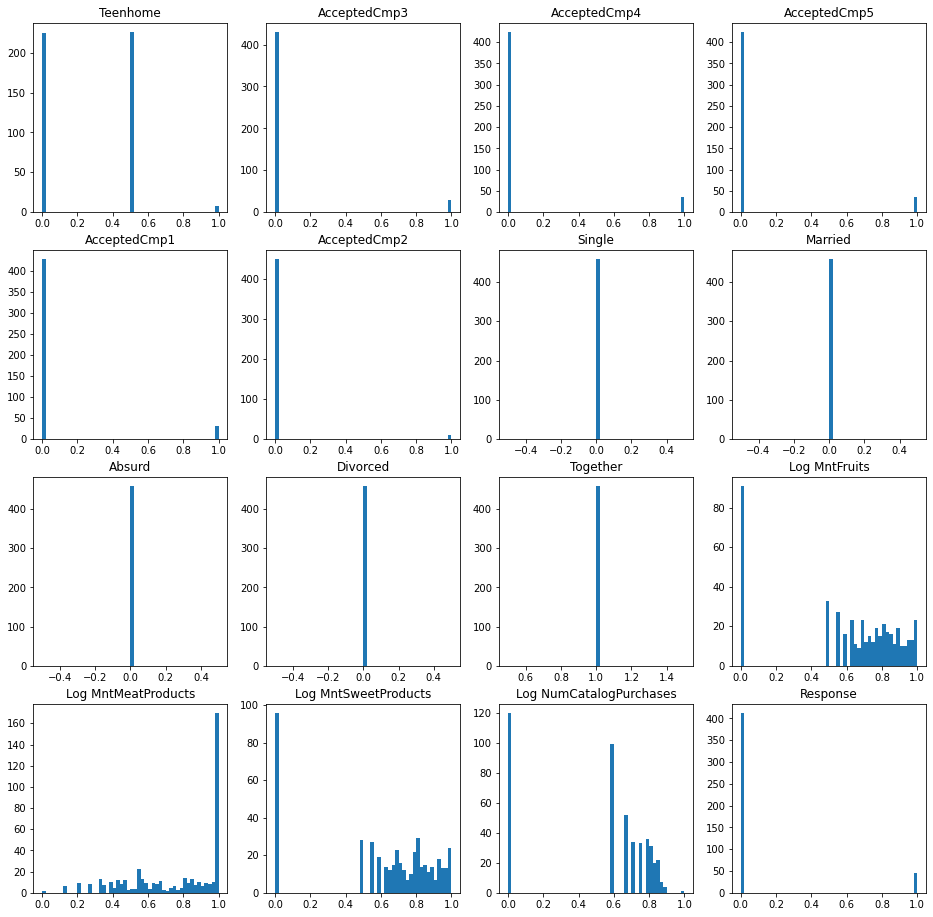

Cluster:  1
nº of samples:  252
Response (positive):  29.9 %
Teenhome (mean):  0.312
Log MntFruits (mean):  0.62
Log MntMeatProducts (mean):  0.759
Log MntSweetProducts (mean):  0.612
Log NumCatalogPurchases (mean):  0.55


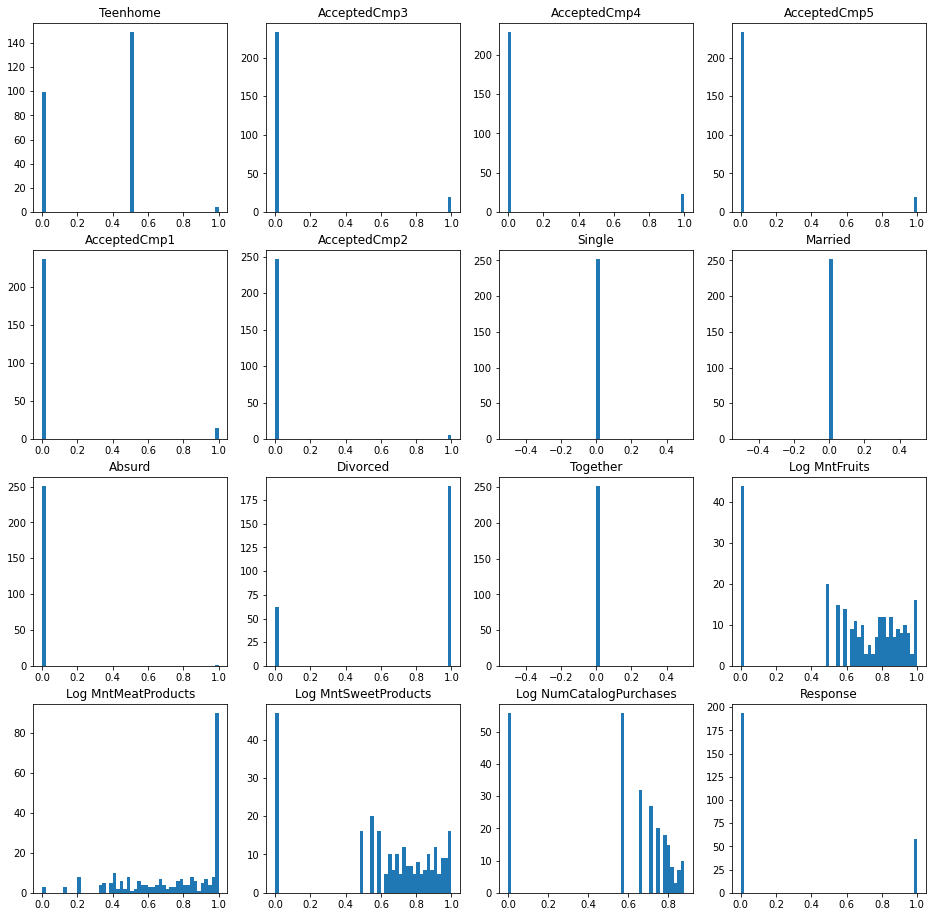

Cluster:  2
nº of samples:  679
Response (positive):  13.4 %
Teenhome (mean):  0.256
Log MntFruits (mean):  0.6
Log MntMeatProducts (mean):  0.746
Log MntSweetProducts (mean):  0.599
Log NumCatalogPurchases (mean):  0.504


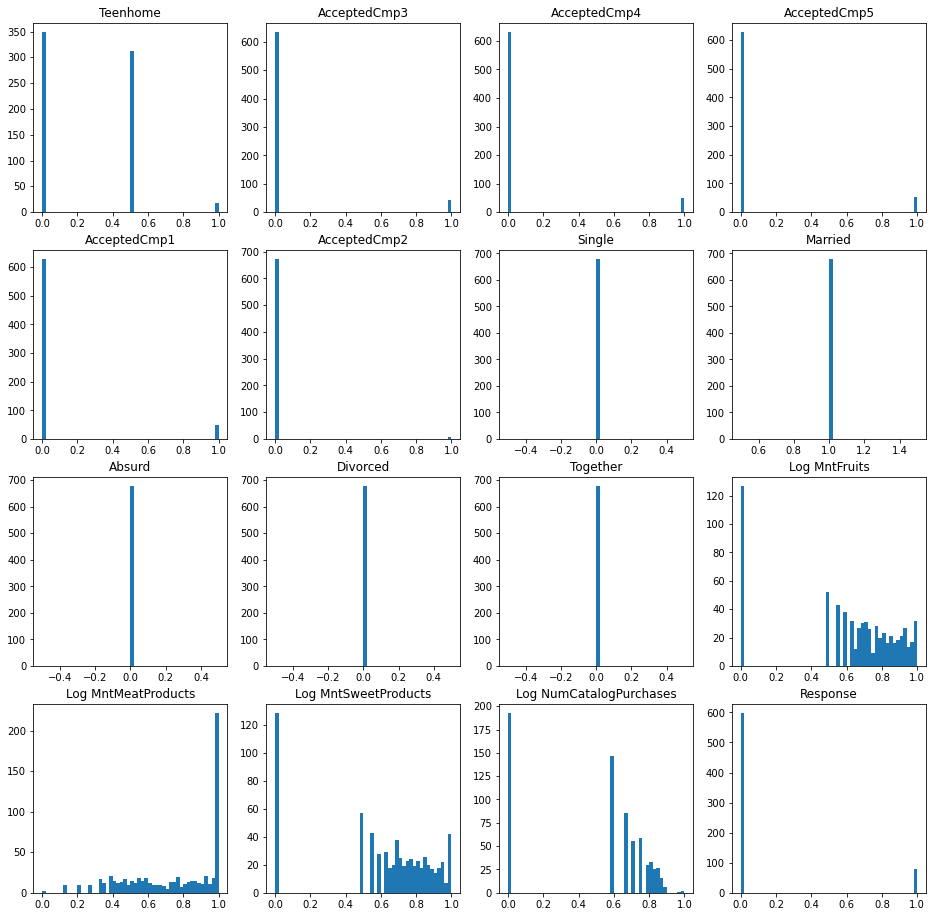

Cluster:  3
nº of samples:  382
Response (positive):  29.9 %
Teenhome (mean):  0.195
Log MntFruits (mean):  0.634
Log MntMeatProducts (mean):  0.751
Log MntSweetProducts (mean):  0.611
Log NumCatalogPurchases (mean):  0.521


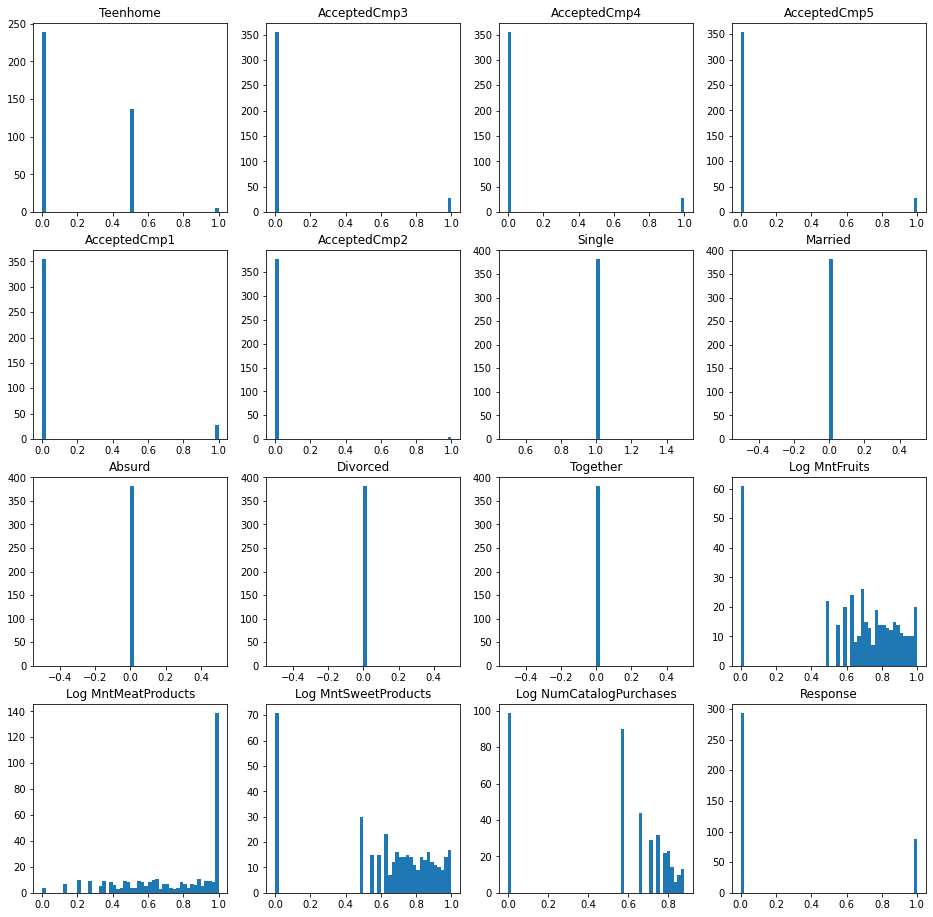

In [19]:
def plot_features(df, label):
    labeled_df = df.loc[df['Label'] == label]
    
    print('Cluster: ', label)
    print('nº of samples: ', len(labeled_df))
    c = Counter(labeled_df['Response'])
    print('Response (positive): ',
          100*np.round(c[1.0]/c[0.0], 3), '%')
    print('Teenhome (mean): ',
          np.round(np.mean(labeled_df['Teenhome']), 3))
    print('Log MntFruits (mean): ',
          np.round(np.mean(labeled_df['Log MntFruits']), 3))
    print('Log MntMeatProducts (mean): ',
          np.round(np.mean(labeled_df['Log MntMeatProducts']), 3))
    print('Log MntSweetProducts (mean): ',
          np.round(np.mean(labeled_df['Log MntSweetProducts']), 3))
    print('Log NumCatalogPurchases (mean): ',
          np.round(np.mean(labeled_df['Log NumCatalogPurchases']), 3))
    
    columns = [column for column in
               labeled_df.columns.values if(column != 'Label')]
    fig, ax = plt.subplots(4, 4, figsize = (16, 16))
    for i, column in enumerate(columns):
        ax[i//4, i%4].hist(labeled_df[column], bins = 50)
        ax[i//4, i%4].set_title(column)
    plt.show()
    
for label in list(set(train_df['Label'])):
    plot_features(train_df, label)

## Conclusions

The two methods applied in this work made it possible to identify relationships between the customers' features in order to predict their behavior on accepting offers in the company's campaigns and to segment them in different groups. Between the main conclusions, it is possible to list:
* The response of the customers in the last marketing campaign was predicted with approximately 80% of accuracy ny means of logistic regression.
* In despite of the imbalance in the data corresponding to the response variable, it was possible to overcome this problem by oversampling the minoritary class.
* The feature selection through $\chi^2$ test was considerably successful, since many numerical variables had sample spaces with size much smaller than the number of observations in the dataset.
* The customers can be segmented in 4 groupings that differ more drastically on the marital status and on the response to the last campaign.
* Based on the dataset, it is possible to say that single and divorced customers were more likely to accept the offers in the last campaign and also presented higher consume pattern in some the company's product categories.

Based on some issues and results observed along this analysis, it is possible to propose the following improvements in future researches:
* Addressing another feature characteristics of the consumers.
* Implementing the results of this analysis in the further campaign strategies of the company.
* Employing a different feature selection method, or a categorization of the variables before the selection, given the inadequacy of the $\chi^2$ test for continuous variables (when the sample space size is comparable to the number of observations).
* Addressing different models in the classification problem.